In [1]:
import numpy
print(numpy.__version__)


1.26.4


In [3]:
pip install opencv-python matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


OpenCV load:
Depth dtype: uint16
Depth min: 0
Depth max: 7016

PIL load:
Depth dtype: uint16
Depth min: 0
Depth max: 7016

Occupancy grid dtype: bool
Original occupancy grid shape: (480, 640)
Unique values in resized occupancy grid: [0]


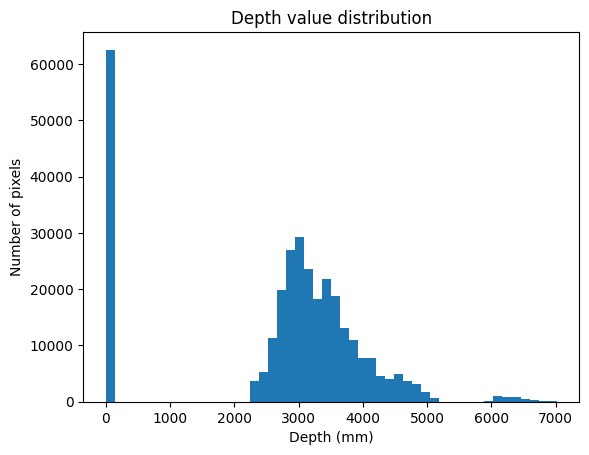

Unique values in resized occupancy grid: [0 1]


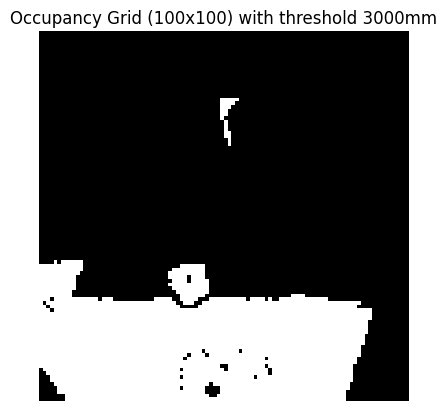

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to your depth image
depth_image_path = r'C:\Users\FPIIC\Downloads\rgbd_dataset_freiburg1_desk\rgbd_dataset_freiburg1_desk\depth\1305031473.190828.png'

# --- Load depth image using OpenCV ---
depth_cv = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

if depth_cv is None:
    raise FileNotFoundError(f"Depth image not found at {depth_image_path}")

print("OpenCV load:")
print("Depth dtype:", depth_cv.dtype)
print("Depth min:", depth_cv.min())
print("Depth max:", depth_cv.max())

# --- Alternative load using PIL ---
depth_pil = np.array(Image.open(depth_image_path))
print("\nPIL load:")
print("Depth dtype:", depth_pil.dtype)
print("Depth min:", depth_pil.min())
print("Depth max:", depth_pil.max())

# Use the PIL-loaded image (should be uint16) for occupancy grid processing
depth = depth_pil

# Threshold for occupancy grid (in mm)
depth_threshold = 1200  # 1.2 meters

# Create occupancy grid: True if obstacle (depth > 0 and less than threshold)
occupancy_grid = (depth > 0) & (depth < depth_threshold)

print("\nOccupancy grid dtype:", occupancy_grid.dtype)
print("Original occupancy grid shape:", occupancy_grid.shape)

# Convert boolean grid to uint8 (0 or 1)
occupancy_grid_uint8 = occupancy_grid.astype(np.uint8)

# Resize to 100x100 for visualization or faster processing
occupancy_grid_small = cv2.resize(occupancy_grid_uint8, (100, 100), interpolation=cv2.INTER_NEAREST)

print("Unique values in resized occupancy grid:", np.unique(occupancy_grid_small))

# Plot histogram of depth values
plt.hist(depth.flatten(), bins=50)
plt.title('Depth value distribution')
plt.xlabel('Depth (mm)')
plt.ylabel('Number of pixels')
plt.show()

# Try a higher threshold
depth_threshold = 3000  # 3 meters

occupancy_grid = (depth > 0) & (depth < depth_threshold)
occupancy_grid_uint8 = occupancy_grid.astype(np.uint8)
occupancy_grid_small = cv2.resize(occupancy_grid_uint8, (100, 100), interpolation=cv2.INTER_NEAREST)

print("Unique values in resized occupancy grid:", np.unique(occupancy_grid_small))

plt.imshow(occupancy_grid_small * 255, cmap='gray')
plt.title(f"Occupancy Grid (100x100) with threshold {depth_threshold}mm")
plt.axis('off')
plt.show()






Path found with 161 steps


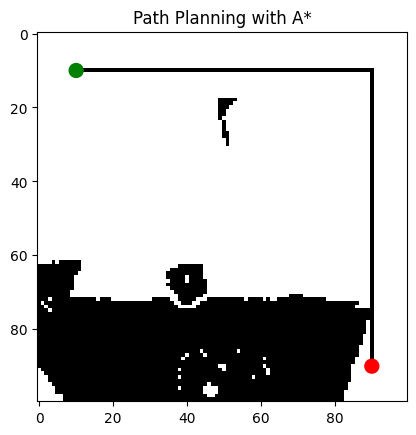

In [15]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

def heuristic(a, b):
    # Manhattan distance heuristic
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(occupancy_grid, start, goal):
    rows, cols = occupancy_grid.shape
    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), 0, start))  # (f, g, node)
    came_from = {}
    g_score = {start: 0}

    directions = [(1,0), (-1,0), (0,1), (0,-1)]  # 4-connected grid

    while open_set:
        f, g, current = heapq.heappop(open_set)

        if current == goal:
            # reconstruct path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        for d in directions:
            neighbor = (current[0] + d[0], current[1] + d[1])

            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if occupancy_grid[neighbor] == 1:
                    # obstacle
                    continue
                tentative_g = g + 1
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score, tentative_g, neighbor))
                    came_from[neighbor] = current

    return None  # no path found


# Example usage:

# occupancy_grid_small is your 100x100 grid
# Make sure free cells are 0, obstacles are 1
# If needed, invert your grid: occupancy_grid_small = 1 - occupancy_grid_small

start = (10, 10)
goal = (90, 90)

path = astar(occupancy_grid_small, start, goal)

if path is None:
    print("No path found")
else:
    print(f"Path found with {len(path)} steps")

    # Visualize
    grid_vis = 1 - occupancy_grid_small.copy()
    for (r, c) in path:
        grid_vis[r, c] = 0.5  # Mark path in gray

    plt.imshow(grid_vis * 255, cmap='gray')
    plt.scatter([start[1], goal[1]], [start[0], goal[0]], c=['green', 'red'], s=100)
    plt.title("Path Planning with A*")
    plt.show()


    
